## Firm Dynamics - Question 2
### Wei Han Chia

In this question, we are provided with a firm facing a fixed adjustment cost and facing a AR-1 productivity shock. We will once again solve this via Value Function Iteration

### Set up

In [43]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time
import numba

# to print plots inline
%matplotlib inline

### Parameters

We will calibrate this model in the same way as question 1. However, in this case, we note that using the $(1- \delta)$ grid points will allow us to capture the value function of not investing easily. Here we have a different adjustment cost, 

$$ c(k',k) = \begin{cases} \psi* k , &I \neq 0 \\ 0, &I = 0 \end{cases} $$

We also have the following parameters:


| Parameter | Description   | Value|
|------|------||------|
    | $\alpha_{k}$ | Capital's share of output | 0.297 |
   | $\alpha_{l}$ | Labor's share of output | 0.650 |
   | $\delta$ | Depreciation rate | 0.154 |
   | $\psi_1$ | Coefficient on fixed adjustment costs | 0.03 |
   | $w$   | Wage rate | 0.700 |
   | $r$   | Interest rate | 0.040 |
   | $\sigma_z$   | Std dev of shocks | 0.213 |
   | $\mu$ | Mean of Income Process | 0 |
   | $\rho$ | Persistence of Income Process | 0.7605 |
   | `sizez` | Number of Grid Points of z | 9 |

In [99]:
# Parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 0.03
w = 0.7
r= 0.04
mu = 0
rho = 0.7605
sigma_z = 0.213
size_z = 9
betafirm = (1 / (1 + r))
params = alpha_k, alpha_l, delta, psi, w, r, betafirm

We will generate the capital grid in the same manner as in the original model, centering our grid around the steady state value solved analytically for the model without adjustment costs. Note here that since we assume $\mu = 0$, it follows that the expected $z = 1$. By creating a $(1-\delta)$ spaced grid, we note that $V(z,k_i) = \pi(z,k_i) + \beta \mathbb{E} V(z, k_{i-1})$ when the individual chooses not to invest. Here, we include one additional grid point for 0, i.e. that the individual chooses not to invest.

We will still use the Rouwenhorst method to discretize our income shock distribution and generate a transition probability matrix. Since we have 9 grid points, we will space our grid out to 4 standard deviations on either end when discretizing our income shock space.

In [82]:
def incomegrid(density, kstar):
    dens = density
    # Bouding state space based on steady state capital
    kbar = 2*kstar
    lb_k = 0.001
    ub_k = kbar
    krat = np.log(lb_k / ub_k)
    numb = np.ceil(krat / np.log(1 - delta))
    K = np.zeros(int(numb * dens) +1)
    # we'll create in a way where we pin down the upper bound - since
    # the distance will be small near the lower bound, we'll miss that by little
    for j in range(int(numb * dens)):
        K[j] = ub_k * (1 - delta) ** (j / dens)
    kvec = K[::-1]
    return kvec

#Compute steady state capital
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1 ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))

kvec2 = incomegrid(1, kstar)

# Generating grid of transition probabilities and nodes
import ar1_approx as ar1
step = (4 * sigma_z) / (size_z/ 2)
pi, zvec2 = ar1.rouwen(rho, mu, step, size_z)

Next, we want to define our matrix for per period flows. We know that given any choice of capital investment, the profit for the  period is as follows.
$$\pi(k,z) =\left(1-\alpha_{l}\right)z\left(\frac{\alpha_{l}}{w}\right)^{\frac{\alpha_{l}}{1-\alpha_{l}}}k^{\frac{\alpha_{k}}{1-\alpha_{l}}} $$

However, for the per period flow, we see that we have two choices,
$$ e(k,0) = \pi(k,z)  $$
$$ e(k,k') = \pi(k,z) - (k'-(1-\delta)k) -\psi_1k $$

We will factor that into constructing our grid of flows.

In [83]:
# Function for computing profit
def profit(k,z, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    return ((1 - alpha_l) * ((np.exp(z)) **(1/(1-alpha_l))) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
      ((k ** alpha_k) ** (1 / (1 - alpha_l))))

@numba.jit
def flows(kvec,zvec, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    size_k = kvec.shape[0]
    size_z = zvec.shape[0]
    e = np.zeros((size_k,size_k,size_z))
    for i in range(size_k):
        for j in range(size_k):
            if j == 0:
                for k in range(size_z):
                    e[i,j,k] = (profit(kvec[i], zvec[k], params))
            else:
                for k in range(size_z):
                    e[i,j,k] = profit(kvec[i], zvec[k], params) - kvec[j] - (1-delta)*kvec[i] - psi * kvec[i]
    return e

In [100]:
e = flows(kvec2, zvec2, params)

Note that this code gives us potentially negative flows. However, we know that for any state k and z, our firms have some non-negative option of investment, which ensures that at optimum these negative values are never attained.

### VFI

Now we move on with Value Function Iteration. Here we note that the only difference in our choice of value function liess in comparing all potential choices for the next period value function. Therefore, we include an additional max operator in our loop.

In [95]:
#  VFI

def VFI(kvec, zvec, e, prob, params, tol=1e-6,maxiter=3000):
    '''
    kvec = grid of capital values
    zvec = grid of shock realisations
    e = grid of potential flows in each period
    prob = transition probability matrix
    params = firm level parameters
    tol = tolerance of VFI
    maxiter = maximum iterations
    
    Purpose: Compute value function and policy function through VFI
    for a dynamic firm model with quadratic adjustment costs'''
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    size_k = kvec.shape[0]
    size_z = zvec.shape[0]
    VFtol = tol
    VFdist = 7.0
    VFmaxiter = maxiter
    V = np.zeros((size_k, size_z))  # k by z size matrix
    Vmat = np.zeros((size_k, size_k, size_z))  # initialize Vmat matrix
    Vmat2 = np.zeros((size_k, size_k, size_z)) # Alternate matrix to keep track of choice of investment
    VFiter = 1
    start_time = time.clock()
    
    while VFdist > VFtol and VFiter < VFmaxiter:
        TV = V
        PF = np.zeros((size_k, size_z))
        for j in range(size_k):  # loop over k'               
            for k in range(size_z):  # loop over z
                for i in range(size_k): # Loop over k
                    if i == 0:
                        Vmat[i,j,k] = 0
                        Vmat2[i,j,k] = 0
                    else:
                        a = e[i, j, k] + betafirm * V[j,:].dot(prob[:,k])
                        b = e[i, 0, k] + betafirm*V[i-1,:].dot(prob[:,k])
                        Vmat[i, j, k] = max(a,b)
                        if  a < b: #Better to not invest
                            Vmat2[i,i-1,k] = max(b, Vmat2[i,i-1,k])
                        else:
                            Vmat2[i,j,k] = e[i, j, k] + betafirm * V[j,:].dot(prob[:,k])
        V = Vmat.max(axis=1)  # apply max operator to Vmat (to get V(k))
        PF = np.argmax(Vmat2, axis=1)  # find the index of the optimal k'
        VFdist = (np.absolute(V - TV)).max()  # check distance between value
        # function for this iteration and value function from past iteration
        VFiter += 1

    VFI_time = time.clock() - start_time
    if VFiter < VFmaxiter:
        print('Value function converged after this many iterations:', VFiter)
    else:
        print('Value function did not converge')
    print('VFI took ', VFI_time, ' seconds to solve')
        
    return V, PF  # solution to the functional equation
    


In [86]:
# Backing out policy functions

@numba.jit
def policy(PF, kvec, zvec, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    size_k = kvec.shape[0]
    size_z = zvec.shape[0]
    optK = kvec[PF]
    optI = np.empty((size_k, size_z))
    for i in range(size_z):
        optI[:,i] = optK[:,i] - (1 - delta) * kvec
    return optK, optI


In [101]:
# Solving for Value Function and Policy Functions at Steady State
V, PF = VFI(kvec2, zvec2, e, pi, params)
optK, optI = policy(PF, kvec2, zvec2, params)

Value function converged after this many iterations: 350
VFI took  206.03634661910473  seconds to solve


### Results

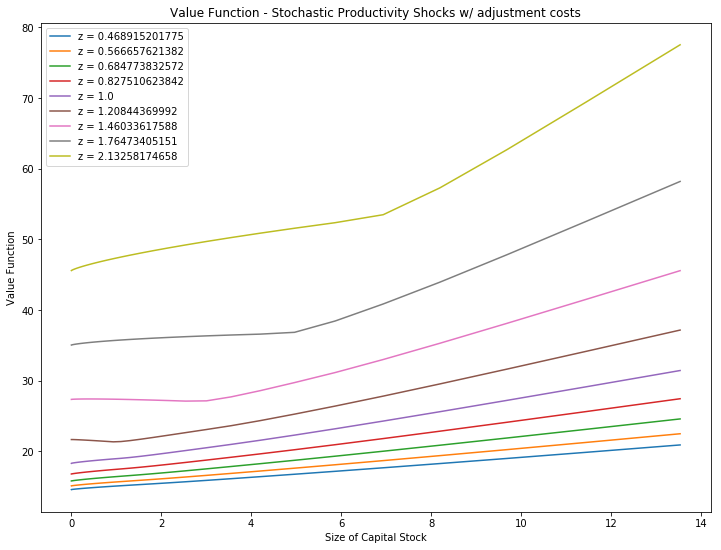

In [102]:
# Plotting Value Functions
plt.rcParams["figure.figsize"] = [12,9]
for i in range(9):
    plt.plot(kvec2[1:], V[1:,i], label='z = '+str(np.exp(zvec2[i])))
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - Stochastic Productivity Shocks w/ adjustment costs')
plt.legend()
plt.show()

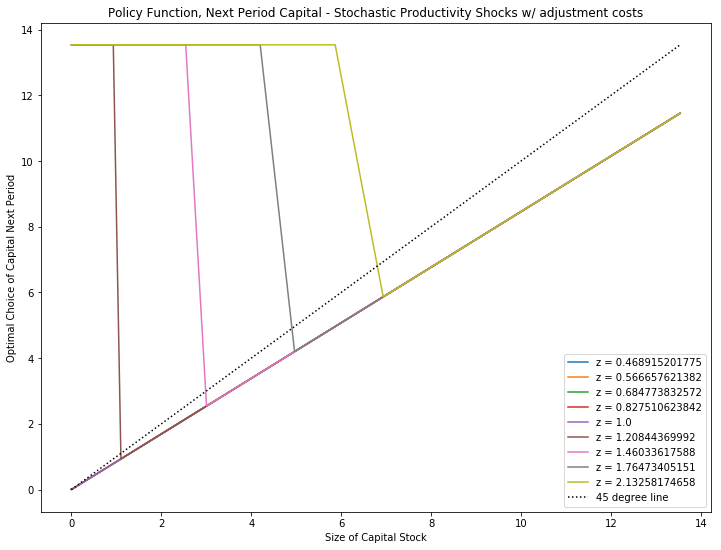

In [103]:
for i in range(9):
    plt.plot(kvec2[1:], optK[1:,i], label='z = '+str(np.exp(zvec2[i])))
plt.plot(kvec2, kvec2, 'k:', label='45 degree line')
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capital - Stochastic Productivity Shocks w/ ' +
          'adjustment costs')
plt.legend()
plt.show()

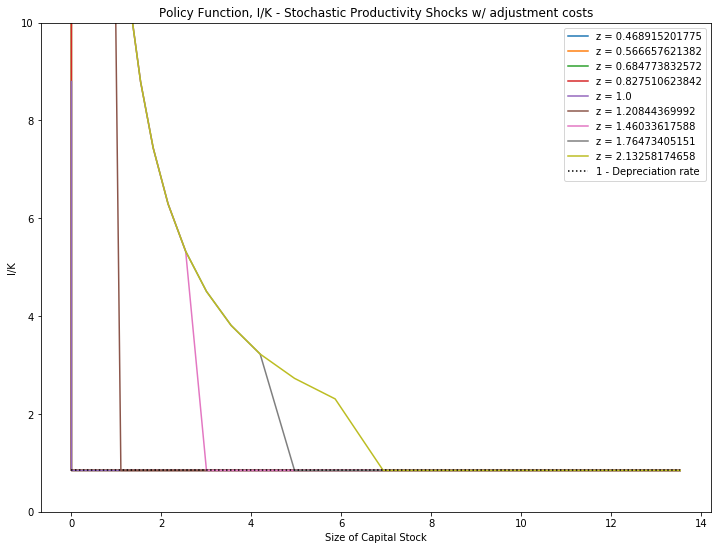

In [105]:
for i in range(9):
    plt.plot(kvec2[1:], optK[1:,i]/kvec2[1:], label='z = '+str(np.exp(zvec1[i])))
plt.plot(kvec2[1:],(np.ones(kvec2.shape[0]-1)*(1-delta)), 'k:', label='1 - Depreciation rate')
plt.xlabel('Size of Capital Stock')
plt.ylim((0,10))
plt.ylabel('I/K')
plt.title('Policy Function, I/K - Stochastic Productivity Shocks w/ ' +
          'adjustment costs')
plt.legend()
plt.show()

The results here are significantly different from before, notably because of the discontuniuty in the first order conditions. Importantly, we see that the optimal investment for each firm is at a maximum level until a threshold where the firm chooses not to invest. This threshold is increasing in z.